In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data
from data import DURATION, WIDTH, HEIGHT
import GPy
from GPy.models import GPRegression
from numpy import ndarray


In [2]:
input_field_names = ["psl", "uas", "vas", "pr", "sfcWind"]
d = len(input_field_names)
input_fields = [data.load_field(name)[1] for name in input_field_names]
all_inputs = np.stack([f.values for f in input_fields], axis=4)
all_inputs = all_inputs.reshape(DURATION, HEIGHT, WIDTH, d)

def field_d(name: str) -> int:
    """Returns the dimension in the input tensor containing the given field."""
    return input_field_names.index(name)

_, wsgsmax_field = data.load_field("wsgsmax")
all_wsgsmax = wsgsmax_field.values.reshape(DURATION, HEIGHT, WIDTH)

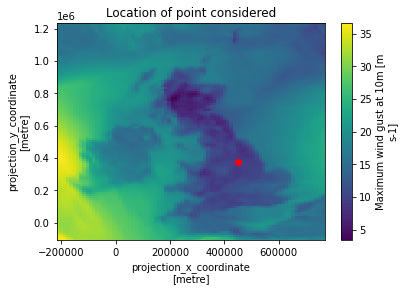

In [42]:
train_start = 500
train_length = 1080
val_length = 1080
test_length = 1080
val_start = train_start + train_length
test_start = val_start + val_length
train_time = np.arange(train_start, train_start + train_length, 1)
val_time = np.arange(val_start, val_start + val_length, 1)
test_time = np.arange(test_start, test_start + test_length + test_length, 1)

# We also look at some time slices far in the future, to see if the model still works.
future_val_times = [
    np.arange(20000, 20000 + val_length, 1),
    np.arange(25000, 25000 + val_length, 1),
    np.arange(34000, 34000 + val_length, 1),
]

x = 55
y = 40

train_inputs = all_inputs[train_time, y, x, :]
train_wsgsmax = all_wsgsmax[train_time, y, x]
val_inputs = all_inputs[val_time, y, x, :]
val_wsgsmax = all_wsgsmax[val_time, y, x]
test_inputs = all_inputs[test_time, y, x, :]
test_wsgsmax = all_wsgsmax[test_time, y, x]
future_val_inputs = [all_inputs[fvt, y, x, :] for fvt in future_val_times]
future_val_wsgsmax = [all_wsgsmax[fvt, y, x] for fvt in future_val_times]

wsgsmax_field[0,0].plot()
plt.title("Location of point considered")
plt.scatter([wsgsmax_field.projection_x_coordinate[x]], [wsgsmax_field.projection_y_coordinate[y]], color="red")
plt.show()

17.334094429016112


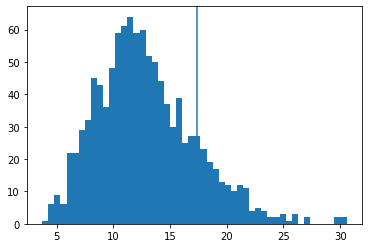

In [4]:
# Take a look at what extreme values of wsgsmax look like, in our area and timeframe
plt.hist(train_wsgsmax.reshape(-1), bins=50)
percentile = np.percentile(train_wsgsmax, 85)
print(percentile)
plt.axvline(percentile)
plt.show()

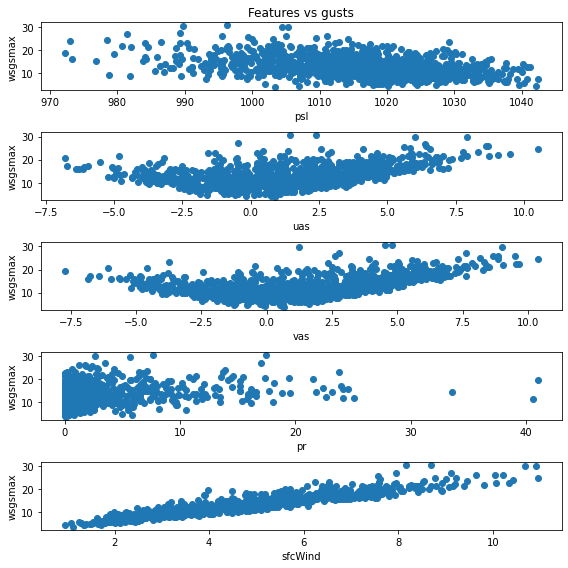

In [5]:
fig, axes = plt.subplots(len(input_field_names), figsize=(8,8))
for i, (name, ax) in enumerate(zip(input_field_names, axes)):
    ax.scatter(train_inputs[:, i], train_wsgsmax)
    ax.set_ylabel("wsgsmax")
    ax.set_xlabel(name)
axes[0].set_title("Features vs gusts")
plt.tight_layout()
plt.show()

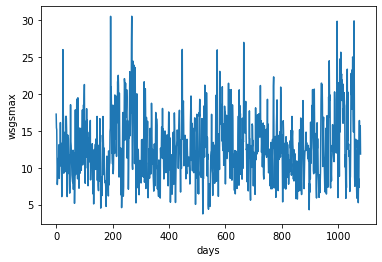

In [6]:
plt.plot(range(train_wsgsmax.shape[0]), train_wsgsmax)
plt.xlabel("days")
plt.ylabel("wsgsmax")
plt.show()

In [46]:
def mse(preds: ndarray, targets: ndarray) -> float:
    return ((preds.reshape(-1) - targets.reshape(-1)) ** 2).mean().item()

def evaluate(model: GPRegression, plot=True, inputs=val_inputs, targets=val_wsgsmax):
    # We consider MSE for all points, and MSE for "extreme" gusts
    # The hope is that considering the "extreme" gusts will help us hit the peaks
    extreme_gust_speed = 21
    means, vars = model.predict(inputs)

    all_mse = mse(means, targets)

    extreme_indices = targets > extreme_gust_speed
    extreme_mse = mse(means[extreme_indices], targets[extreme_indices])
    extremes_missed = (means[extreme_indices] + 2 * np.sqrt(vars[extreme_indices]) < extreme_gust_speed).sum()
    total_extremes = extreme_indices.sum()

    if plot:
        plot_eval(model, inputs, targets)
    
    return all_mse, extreme_mse, extremes_missed / total_extremes

def plot_eval(model: GPRegression, inputs, targets, n=100):
    short_test = inputs[0:n]
    short_targets = targets[0:n]

    plt.plot(range(short_test.shape[0]), short_targets, label="truth")

    means, vars = model.predict(short_test)
    xs = list(range(short_test.shape[0]))
    ys = means.reshape(-1)
    errors = 2 * np.sqrt(vars.reshape(-1))
    plt.plot(xs, means.reshape(-1), label="preds")
    plt.fill_between(xs, ys - errors, ys + errors, color="C1", alpha=0.3)

    plt.xlabel("days")
    plt.ylabel("wsgsmax")
    plt.title("Results on validation set")
    plt.legend()
    plt.show()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s12  0003   2.255653e+03   1.758522e+04  /home/oscar/nobackup/apps/miniconda3/envs/wind/lib/python3.8/site-packages/GPy/core/gp.py:85: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 5. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel

    00s16  0004   2.206369e+03   2.974313e+03 
    00s81  0022   2.185965e+03   4.378941e-07 
Runtime:     00s81
Optimization status: Converged



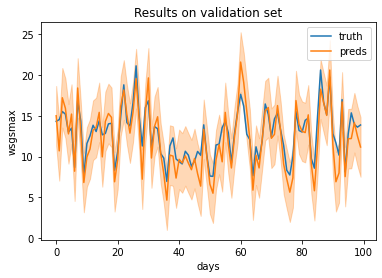

(4.03409310993639, 13.661204710191369, 0.09803921568627451)

In [44]:
# Just a linear model on sfcWind
kernels = [
    GPy.kern.Linear(input_dim=1, active_dims=[field_d("sfcWind")]),
]
kernel = kernels[0]
for k in kernels[1:]:
    kernel = kernel * k
model = GPRegression(train_inputs, train_wsgsmax.reshape(-1, 1), kernel)
model.optimize(messages=True)
evaluate(model)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   4.382344e+03           nan 
    01s24  0009   2.344459e+03   1.165635e+01 
    03s63  0028   2.327719e+03   1.670014e-08 
Runtime:     03s63
Optimization status: Converged



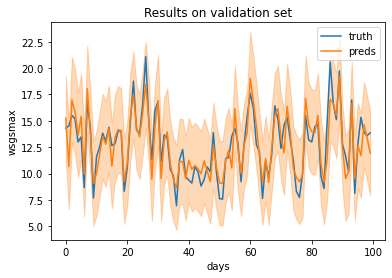

(4.5115229980648515, 24.40414764723636, 0.13725490196078433)

In [37]:
# Good model as selected by grid search:
# - smarter mean: sustained wind speed + the mean additional gust
# - all RBF kernels (lol)
mean_add_gust = (train_wsgsmax - train_inputs[:, field_d("sfcWind")]).mean()
mf = GPy.core.Mapping(train_inputs.shape[1], 1)
mf.f = lambda x: (x[:, field_d("sfcWind")] + mean_add_gust).reshape(-1, 1)
mf.update_gradients = lambda a,b: None

kernels = [
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("psl")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("uas")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("vas")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("pr")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("sfcWind")]),
]
kernel = kernels[0]
for k in kernels[1:]:
    kernel = kernel * k
model = GPRegression(train_inputs, train_wsgsmax.reshape(-1, 1), kernel, mean_function=mf)
model.optimize(messages=True)
evaluate(model)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s10  0005   2.053077e+03   3.160282e+02 
    05s65  0029   1.997173e+03   9.358654e+00 
    09s10  0047   1.996196e+03   2.418875e-01 
    11s41  0059   1.995807e+03   3.229943e-02 
    16s04  0083   1.995694e+03   3.339359e-01 
    21s83  0113   1.995685e+03   1.067521e-04 
    22s81  0118   1.995685e+03   1.615343e-05 
Runtime:     22s81
Optimization status: Converged



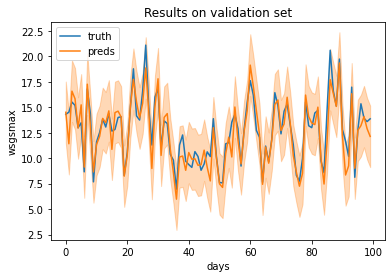

(2.850807227735612, 14.205174699872126, 0.13725490196078433)

In [40]:
# Try adding the kernels rather than using the product.
mean_add_gust = (train_wsgsmax - train_inputs[:, field_d("sfcWind")]).mean()
mf = GPy.core.Mapping(train_inputs.shape[1], 1)
mf.f = lambda x: (x[:, field_d("sfcWind")] + mean_add_gust).reshape(-1, 1)
mf.update_gradients = lambda a,b: None

kernels = [
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("psl")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("uas")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("vas")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("pr")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("sfcWind")]),
]
kernel = kernels[0]
for k in kernels[1:]:
    kernel = kernel + k
model = GPRegression(train_inputs, train_wsgsmax.reshape(-1, 1), kernel, mean_function=mf)
model.optimize(messages=True)
evaluate(model)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s05  0005   2.342384e+03   1.319686e+04 
    05s30  0025   2.003672e+03   8.900372e+02 
    07s42  0035   1.972240e+03   1.278852e+00 
    23s42  0110   1.957521e+03   1.581880e-01 
    27s69  0130   1.956976e+03   1.380422e+00 
    34s10  0160   1.957019e+03   6.975626e+01  /home/oscar/nobackup/apps/miniconda3/envs/wind/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/oscar/nobackup/apps/miniconda3/envs/wind/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/oscar/nobackup/apps/miniconda3/envs/wind/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
    35s21  0165   1.955898e+03   7.952667e+01 
Runtime:     35s21
Optimization status: Converged



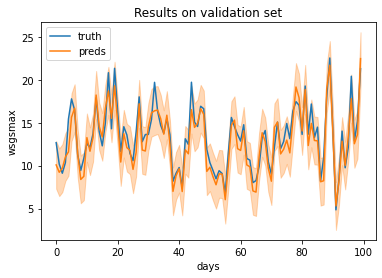

(2.4491913359026403, 10.51484020309038, 0.07692307692307693)


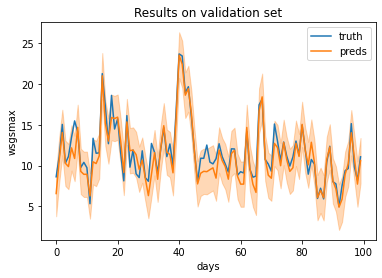

(2.629775086002021, 6.922003412686562, 0.06557377049180328)


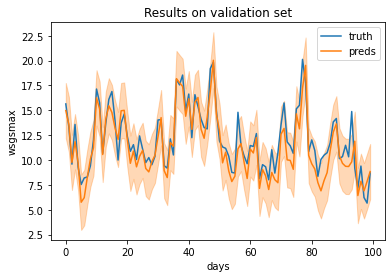

(2.6322585786172197, 7.303407891738964, 0.03076923076923077)


In [47]:
# Try evaluating the model on various time slices in the future.
mean_add_gust = (train_wsgsmax - train_inputs[:, field_d("sfcWind")]).mean()
mf = GPy.core.Mapping(train_inputs.shape[1], 1)
mf.f = lambda x: (x[:, field_d("sfcWind")] + mean_add_gust).reshape(-1, 1)
mf.update_gradients = lambda a,b: None

kernels = [
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("psl")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("uas")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("vas")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("pr")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("sfcWind")]),
]
kernel = kernels[0]
for k in kernels[1:]:
    kernel = kernel * k
model = GPRegression(train_inputs, train_wsgsmax.reshape(-1, 1), kernel, mean_function=mf)
model.optimize(messages=True)

for inputs, targets in zip(future_val_inputs, future_val_wsgsmax):
    print(evaluate(model, inputs=inputs, targets=targets, plot=True))